In [1]:
import os
import sys
import seaborn as sns
import torch

from torch.utils.cpp_extension import load
from tqdm import trange

sns.set()

print('Loading geometry library...')

if not os.path.exists('build'):
    os.makedirs('build')

geom_cpp = load(name="geom_cpp",
        sources=[ "ext/geometry.cpp" ],
        extra_include_paths=[ "glm" ],
        build_directory="build")

Loading geometry library...


In [2]:
import meshio
import imageio

from scripts.geometry import compute_vertex_normals, compute_face_normals
from scripts.load_xml import load_scene

mesh = meshio.read('experiments/meshes/chinese/target.obj')

environment = imageio.imread('experiments/environment.hdr', format='HDR-FI')
environment = torch.tensor(environment, dtype=torch.float32, device='cuda')
alpha = torch.ones((*environment.shape[:2], 1), dtype=torch.float32, device='cuda')
environment = torch.cat((environment, alpha), dim=-1)

sp = load_scene('scenes/dragon/dragon.xml')

scene_parameters = {}
scene_parameters['res_x'] = 1024
scene_parameters['res_y'] = 640
scene_parameters['fov'] = 45.0
scene_parameters['near_clip'] = 0.1
scene_parameters['far_clip'] = 1000.0
scene_parameters['envmap'] = environment
scene_parameters['envmap_scale'] = 1.0

v_ref = torch.from_numpy(mesh.points).float().cuda()
f_ref = torch.from_numpy(mesh.cells_dict['triangle']).int().cuda()
fn_ref = compute_face_normals(v_ref, f_ref)
n_ref = compute_vertex_normals(v_ref, f_ref, fn_ref)

print('vertices:', v_ref.shape, 'faces:', f_ref.shape)

/tmp/ipykernel_6035/3707843544.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  environment = imageio.imread('experiments/environment.hdr', format='HDR-FI')


vertices: torch.Size([124943, 3]) faces: torch.Size([249881, 3])


In [3]:
# Generate camera views
import numpy as np

def lookat(eye, center, up):
    normalize = lambda x: x / torch.norm(x)

    f = normalize(eye - center)
    u = normalize(up)
    s = normalize(torch.cross(f, u))
    u = torch.cross(s, f)

    dot_f = torch.dot(f, eye)
    dot_u = torch.dot(u, eye)
    dot_s = torch.dot(s, eye)

    return torch.tensor([
        [s[0], u[0], -f[0], -dot_s],
        [s[1], u[1], -f[1], -dot_u],
        [s[2], u[2], -f[2], dot_f],
        [0, 0, 0, 1]
    ], device='cuda', dtype=torch.float32)

views = []

# TODO: cluster the faces and then use normal offset...

# Try smaller radius...
# radius = 5.0
splitsTheta = 5
splitsPhi = 5

center = v_ref.mean(axis=0)
radius = 2.0 * torch.norm(v_ref - center, dim=1).mean()

for theta in np.linspace(0, 2 * np.pi, splitsTheta, endpoint=False):
    for i, phi in enumerate(np.linspace(np.pi * 0.1, np.pi * 0.9, splitsPhi, endpoint=True)):
        # Spiral as a function of phi
        ptheta = (2 * np.pi / splitsTheta) * i/splitsPhi
        theta += ptheta

        eye_offset = torch.tensor([
            radius * np.sin(theta) * np.sin(phi),
            radius * np.cos(phi),
            radius * np.cos(theta) * np.sin(phi)
        ], device='cuda', dtype=torch.float32)

        # TODO: random perturbations to the angles

        normalized_eye_offset = eye_offset / torch.norm(eye_offset)

        canonical_up = torch.tensor([0.0, 1.0, 0.0], device='cuda')
        right = torch.cross(normalized_eye_offset, canonical_up)
        up = torch.cross(right, normalized_eye_offset)

        view = lookat(center + eye_offset, center, canonical_up)
        views.append(view)

# TODO: use lookat?
print('Generated %d views' % len(views))
scene_parameters['view_mats'] = views
scene_parameters['view_mats'] = sp['view_mats']

Generated 25 views


In [4]:
import meshio

source = 'experiments/meshes/chinese/source.obj'
mesh = meshio.read(source)

v = mesh.points
f = mesh.cells_dict['quad']

v = torch.from_numpy(v).float().cuda()

print('Quadrangulated shape; vertices:', v.shape, 'faces:', f.shape)

# Configure neural subdivision complex parameters
from models import *

# TODO: no need for this...
nsc = NSubComplex().cuda()

points = v
complexes = torch.from_numpy(f).int().cuda()
encodings = torch.zeros((points.shape[0], POINT_ENCODING_SIZE), requires_grad=True, device='cuda')

Quadrangulated shape; vertices: torch.Size([1002, 3]) faces: (999, 4)


In [5]:
# TODO: keep these functions in the scrits directory

# Sampling methods for the neural subdivision complex
def lerp(X, U, V):
    lp00 = X[:, 0, :].unsqueeze(1) * U.unsqueeze(-1) * V.unsqueeze(-1)
    lp01 = X[:, 1, :].unsqueeze(1) * (1.0 - U.unsqueeze(-1)) * V.unsqueeze(-1)
    lp10 = X[:, 3, :].unsqueeze(1) * U.unsqueeze(-1) * (1.0 - V.unsqueeze(-1))
    lp11 = X[:, 2, :].unsqueeze(1) * (1.0 - U.unsqueeze(-1)) * (1.0 - V.unsqueeze(-1))
    return lp00 + lp01 + lp10 + lp11

def sample(sample_rate):
    U = torch.linspace(0.0, 1.0, steps=sample_rate).cuda()
    V = torch.linspace(0.0, 1.0, steps=sample_rate).cuda()
    U, V = torch.meshgrid(U, V)

    corner_points = points[complexes, :]
    corner_encodings = encodings[complexes, :]

    U, V = U.reshape(-1), V.reshape(-1)
    U = U.repeat((complexes.shape[0], 1))
    V = V.repeat((complexes.shape[0], 1))

    lerped_points = lerp(corner_points, U, V).reshape(-1, 3)
    lerped_encodings = lerp(corner_encodings, U, V).reshape(-1, POINT_ENCODING_SIZE)

    return lerped_points, lerped_encodings

def indices(sample_rate):
    triangles = []
    for i in range(sample_rate - 1):
        for j in range(sample_rate - 1):
            a = i * sample_rate + j
            c = (i + 1) * sample_rate + j
            b, d = a + 1, c + 1
            triangles.append([a, b, c])
            triangles.append([b, d, c])

    return np.array(triangles)

def sample_rate_indices(sample_rate):
    tri_indices = []
    for i in range(complexes.shape[0]):
        ind = indices(sample_rate)
        ind += i * sample_rate ** 2
        tri_indices.append(ind)

    tri_indices = np.concatenate(tri_indices, axis=0)
    tri_indices_tensor = torch.from_numpy(tri_indices).int().cuda()
    return tri_indices_tensor

def make_cmap(complexes, LP, sample_rate):
    Cs = complexes.cpu().numpy()
    lp = LP.detach().cpu().numpy()

    cmap = dict()
    for i in range(Cs.shape[0]):
        for j in Cs[i]:
            if cmap.get(j) is None:
                cmap[j] = set()

        corners = np.array([
            0, sample_rate - 1,
            sample_rate * (sample_rate - 1),
            sample_rate ** 2 - 1
        ]) + (i * sample_rate ** 2)

        qvs = points[Cs[i]].cpu().numpy()
        cvs = lp[corners]

        for j in range(4):
            # Find the closest corner
            dists = np.linalg.norm(qvs[j] - cvs, axis=1)
            closest = np.argmin(dists)
            cmap[Cs[i][j]].add(corners[closest])

    return cmap

def average_edge_length(V, T):
    v0 = V[T[:, 0], :]
    v1 = V[T[:, 1], :]
    v2 = V[T[:, 2], :]

    v01 = v1 - v0
    v02 = v2 - v0
    v12 = v2 - v1

    l01 = torch.norm(v01, dim=1)
    l02 = torch.norm(v02, dim=1)
    l12 = torch.norm(v12, dim=1)
    return (l01 + l02 + l12).mean()/3.0

def triangle_areas(v, f):
    v0 = v[f[:, 0], :]
    v1 = v[f[:, 1], :]
    v2 = v[f[:, 2], :]
    v01 = v1 - v0
    v02 = v2 - v0
    return 0.5 * torch.norm(torch.cross(v01, v02), dim=1)

In [6]:
import matplotlib.pyplot as plt

from scripts.render import NVDRenderer

renderer = NVDRenderer(scene_parameters, shading=True, boost=3)

def preview(V, N, F, size=5, title='Preview'):
    imgs = renderer.render(V, N, F)
    fig, axs = plt.subplots(size, 1, figsize=(40, 20))
    for i, ax in enumerate(axs):
        ax.set_title(title + f': {i}')
        ax.imshow((imgs[i,...].clip(0,1)).cpu().numpy(), origin='lower')
        ax.axis('off')
    plt.axis('off')
    return imgs

def preview_nsc(sample_rate, title='Preview (NSC)'):
    LP, LE = sample(sample_rate)
    V = nsc(LP, LE)

    V = V.detach()
    F = sample_rate_indices(sample_rate)
    Fn = compute_face_normals(V, F)
    N = compute_vertex_normals(V, F, Fn)

    preview(V, N, F, title=title)

In [7]:
def subdivide(V, complex_count, sample_rate):
    Vreshaped = V.reshape(complex_count, sample_rate, sample_rate, 3)
    print('Vreshaped', Vreshaped.shape)

    Vsub = []
    for Vcomplex in Vreshaped:
        Vcomplex_sub = []
        for u in range(sample_rate * 2):
            for v in range(sample_rate * 2):
                iu = (sample_rate - 1) * u / (sample_rate * 2 - 1)
                iv = (sample_rate - 1) * v / (sample_rate * 2 - 1)

                iu0 = int(np.floor(iu))
                iu1 = int(np.ceil(iu))
                iv0 = int(np.floor(iv))
                iv1 = int(np.ceil(iv))

                du = iu - iu0
                dv = iv - iv0

                v00 = Vcomplex[iu0, iv0, :]
                v01 = Vcomplex[iu0, iv1, :]
                v10 = Vcomplex[iu1, iv0, :]
                v11 = Vcomplex[iu1, iv1, :]

                v0 = v00 * (1.0 - dv) + v01 * dv
                v1 = v10 * (1.0 - dv) + v11 * dv
                v = v0 * (1.0 - du) + v1 * du

                Vcomplex_sub.append(v)

        Vcomplex_sub = torch.stack(Vcomplex_sub, dim=0)
        Vsub.append(Vcomplex_sub)
    
    Vsub = torch.cat(Vsub, dim=0)
    print('Vsub', Vsub.shape)

    return Vsub.reshape(-1, 3)

In [8]:
from largesteps.parameterize import from_differential, to_differential
from largesteps.geometry import compute_matrix, laplacian_uniform
from largesteps.optimize import AdamUniform

from scripts.geometry import remove_duplicates

steps = 1000       # Number of optimization steps
step_size = 1e-2   # Step size
lambda_ = 10     # Hyperparameter lambda of our method, used to compute the matrix (I + lambda_ * L)

def inverse_render(V, base, sample_rate):
    print(f'Inverse rendering at sample rate {sample_rate}...')

    # Get the reference images
    ref_imgs = renderer.render(v_ref, n_ref, f_ref)
    
    # Optimization setup
    cmap = make_cmap(complexes, base, sample_rate)
    F, remap = geom_cpp.sdc_weld(complexes.cpu(), cmap, base.shape[0], sample_rate)
    F = F.cuda()

    M = compute_matrix(V, F, lambda_)
    assert not torch.isnan(M).any()

    U = to_differential(M, V)
    assert not torch.isnan(U).any()

    U.requires_grad = True
    opt = AdamUniform([ U ], step_size)
    
    # preview(v_ref, n_ref, f_ref, title='Reference')   
    # Fn = compute_face_normals(V, F)
    # N = compute_vertex_normals(V, F, Fn)
    # preview(V, N.detach(), F, title='Initial')

    # Optimization loop
    losses =  {}
    for it in trange(steps):
        V = from_differential(M, U, 'Cholesky')
        
        Fn = compute_face_normals(V, F)
        assert not torch.isnan(Fn).any()

        N = compute_vertex_normals(V, F, Fn)
        assert not torch.isnan(N).any()

        # Render images
        opt_imgs = renderer.render(V, N, F)

        # Compute losses
        render_loss = (opt_imgs - ref_imgs).abs().mean()
        area_loss = triangle_areas(V, F).var()
        loss = render_loss # + 1e3 * area_loss

        losses.setdefault('render', []).append(render_loss.item())
        losses.setdefault('area', []).append(area_loss.item())

        # Backpropagate
        opt.zero_grad()
        loss.backward()
        opt.step()

    V = geom_cpp.sdc_separate(V.detach().cpu(), remap).cuda()

    preview(V, N.detach(), F, title='Optimized')

    fig = plt.figure(figsize=(20, 10))
    plt.plot(losses['render'], label='render')
    # plt.plot(losses['area'], label='area')
    plt.yscale('log')
    plt.legend()

    return V

/home/venki/.local/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


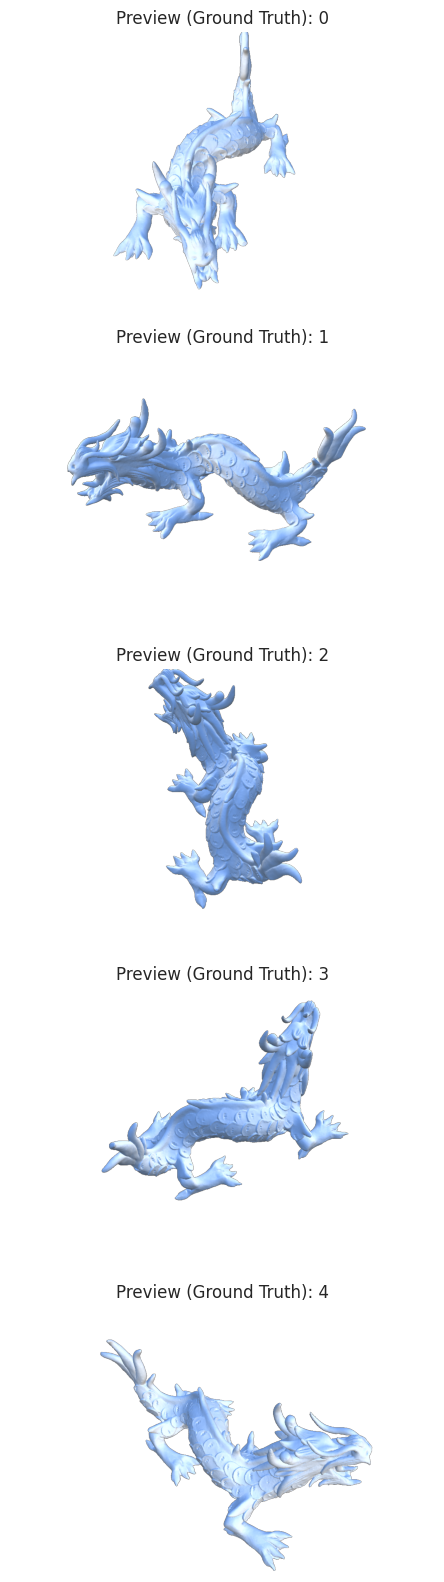

In [9]:
base4, _ = sample(4)
base8, _ = sample(8)
base16, _ = sample(16)

_ = preview(v_ref, n_ref, f_ref, size=5, title='Preview (Ground Truth)')

Inverse rendering at sample rate 4...
cs: 999


100%|██████████| 1000/1000 [00:38<00:00, 25.85it/s]


Vreshaped torch.Size([999, 4, 4, 3])
Vsub torch.Size([63936, 3])
Inverse rendering at sample rate 8...
cs: 999


100%|██████████| 1000/1000 [00:55<00:00, 18.03it/s]


Vreshaped torch.Size([999, 8, 8, 3])
Vsub torch.Size([255744, 3])
Inverse rendering at sample rate 16...
cs: 999


100%|██████████| 1000/1000 [02:15<00:00,  7.41it/s]


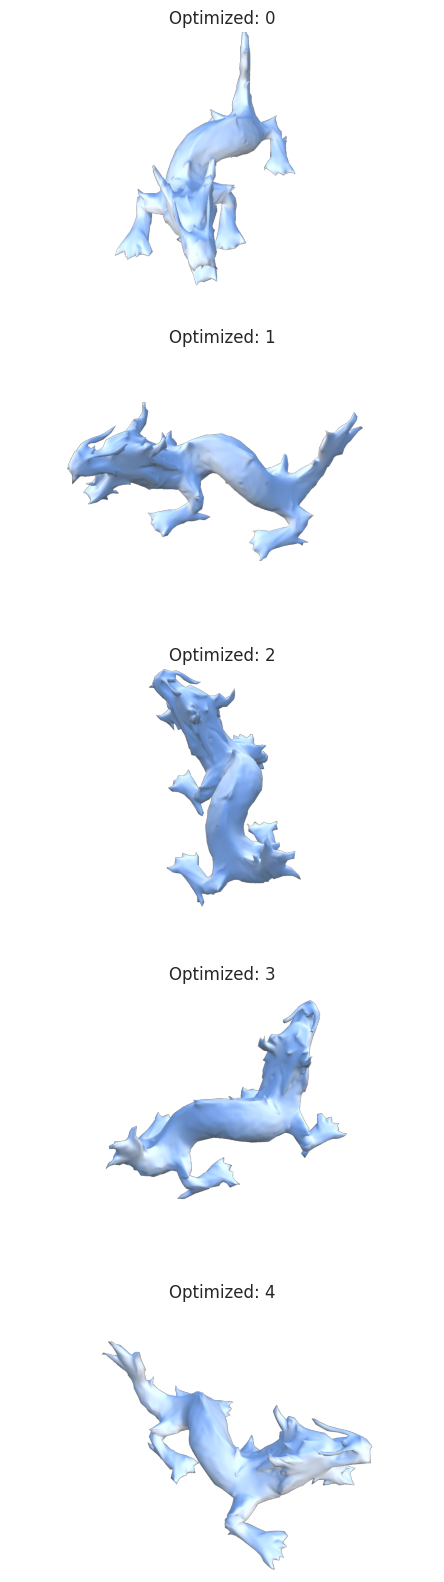

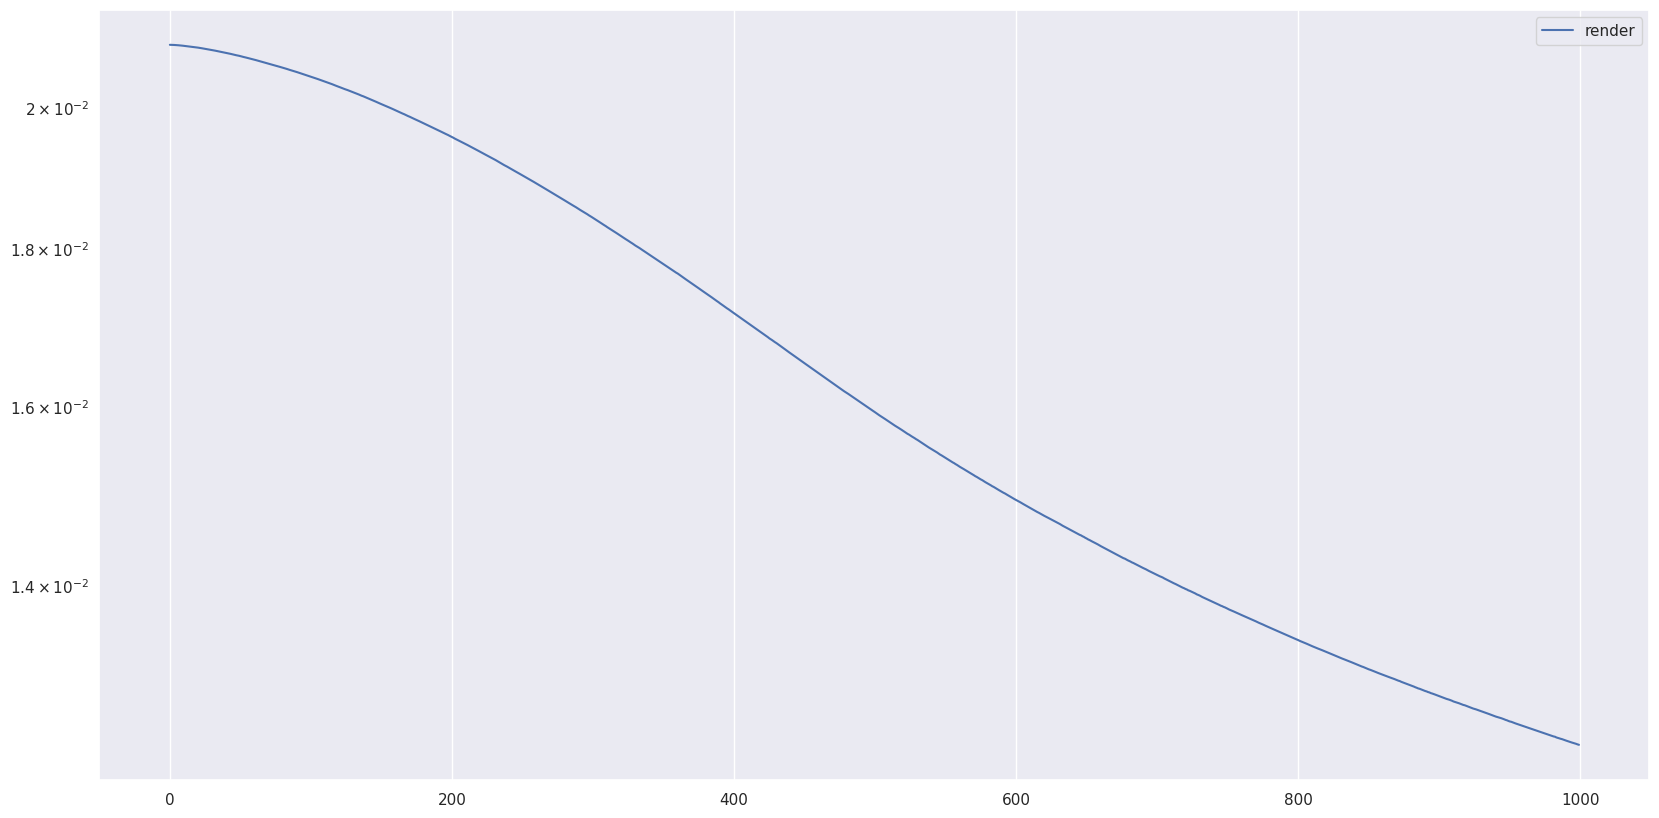

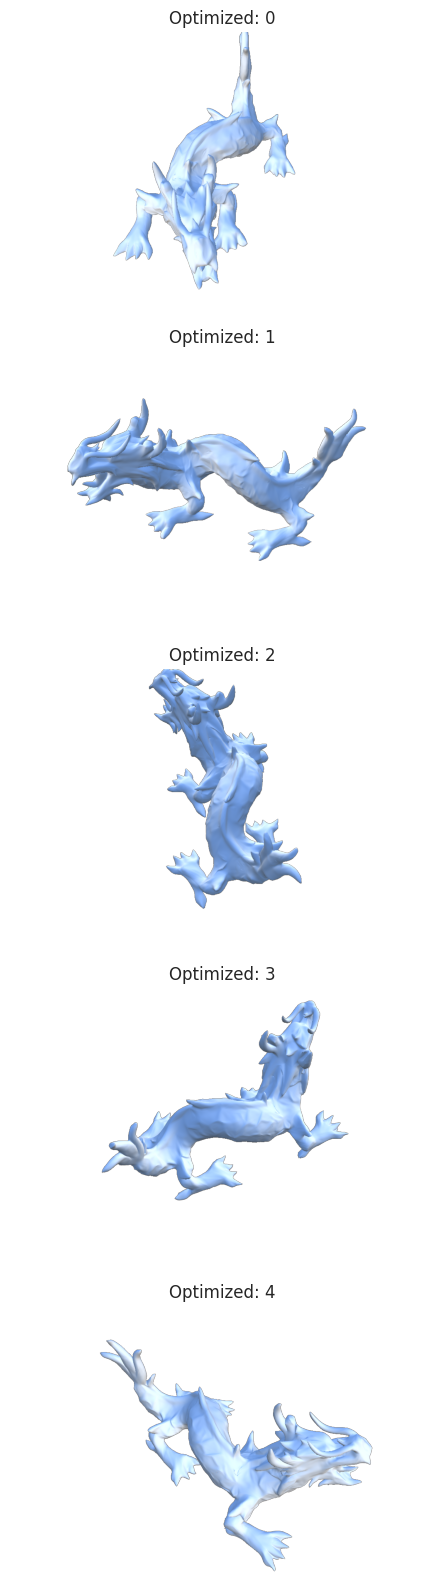

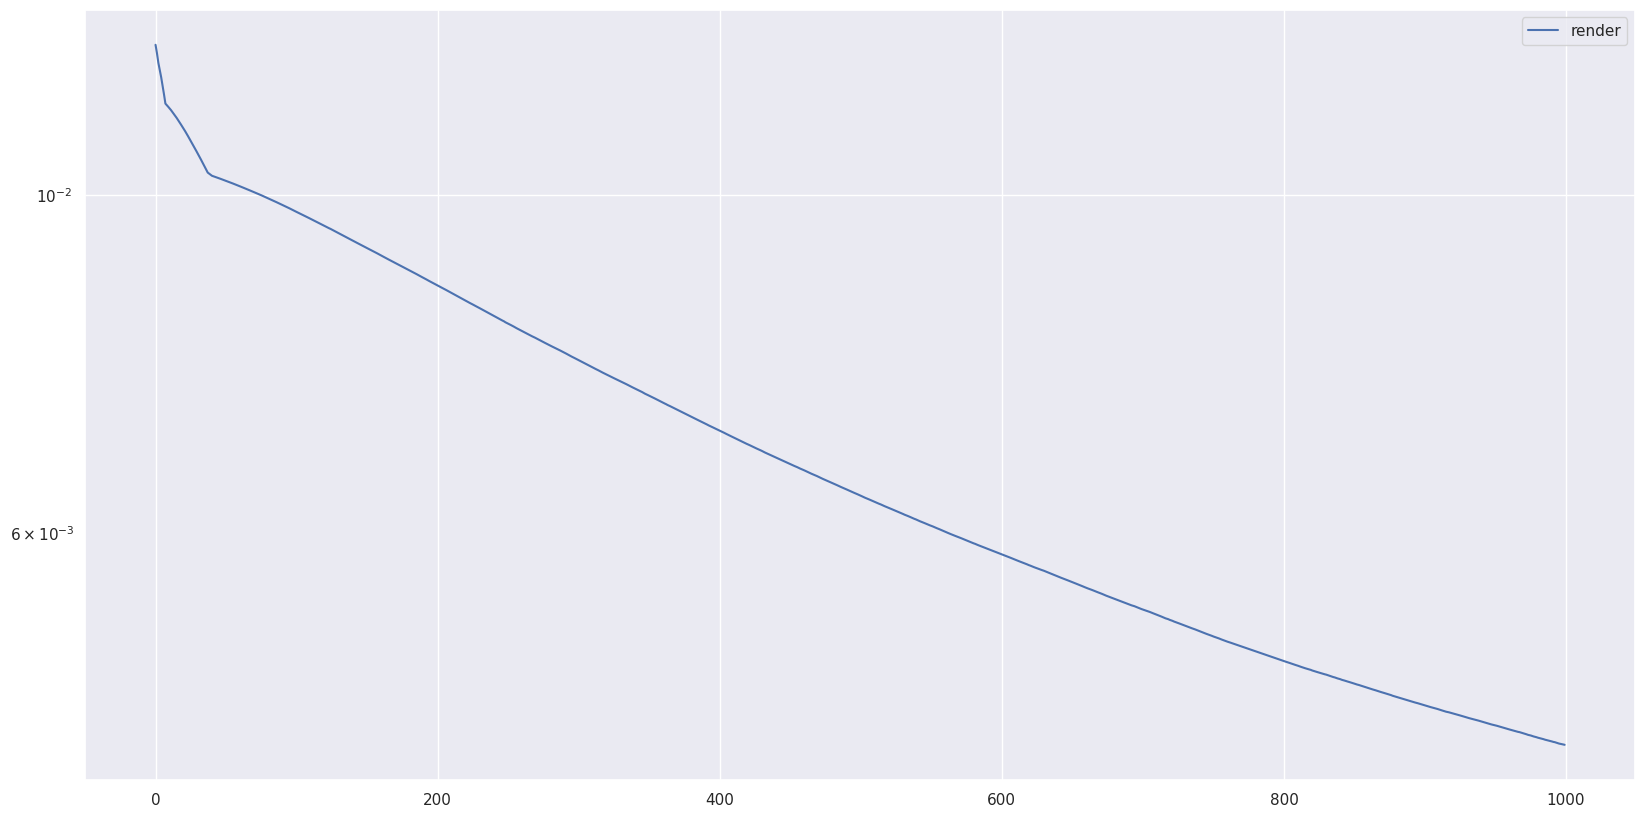

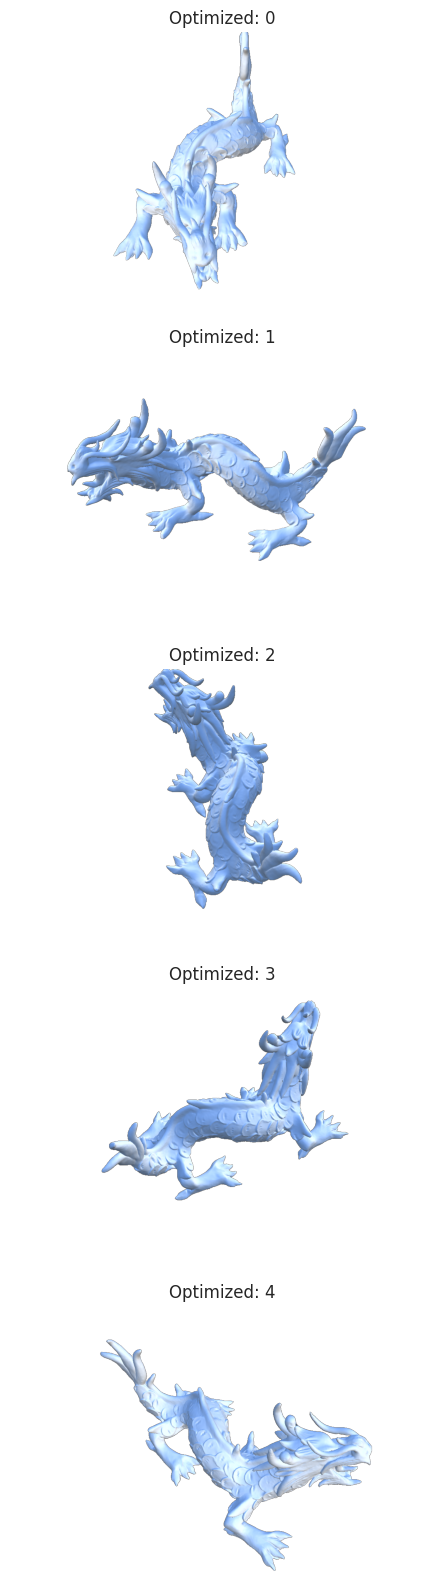

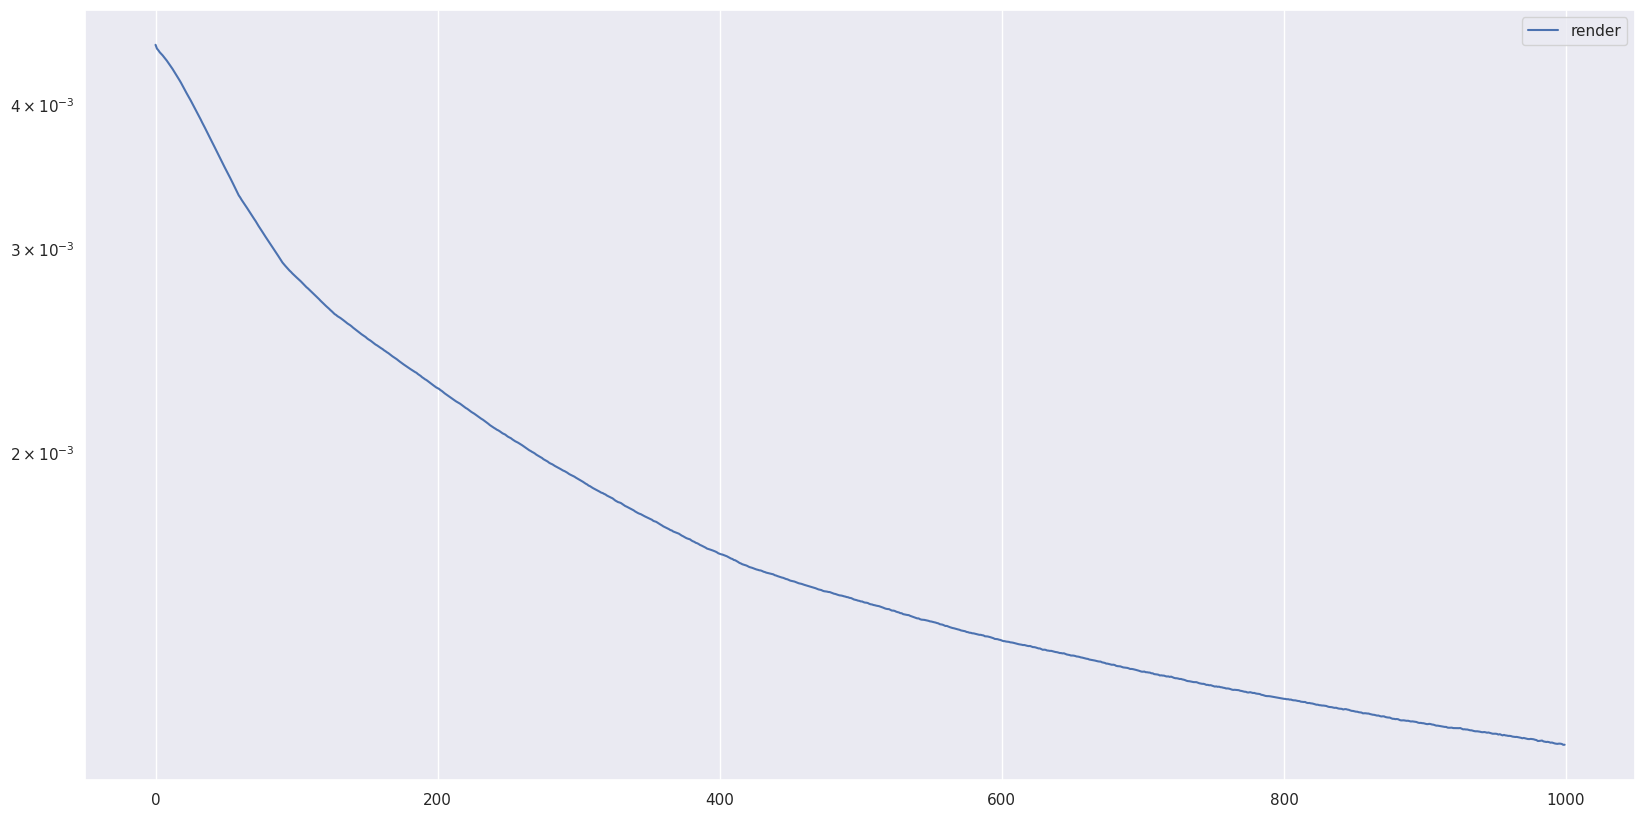

In [10]:
V4 = inverse_render(base4, base4, 4)
V8 = inverse_render(subdivide(V4, complexes.shape[0], 4), base8, 8)
V16 = inverse_render(subdivide(V8, complexes.shape[0], 8), base16, 16)

In [11]:
import polyscope as ps

def color_code_complexes(C, sample_rate=16):
    color_wheel = [
            np.array([0.700, 0.300, 0.300]),
            np.array([0.700, 0.450, 0.300]),
            np.array([0.700, 0.600, 0.300]),
            np.array([0.650, 0.700, 0.300]),
            np.array([0.500, 0.700, 0.300]),
            np.array([0.350, 0.700, 0.300]),
            np.array([0.300, 0.700, 0.400]),
            np.array([0.300, 0.700, 0.550]),
            np.array([0.300, 0.700, 0.700]),
            np.array([0.300, 0.550, 0.700]),
            np.array([0.300, 0.400, 0.700]),
            np.array([0.350, 0.300, 0.700]),
            np.array([0.500, 0.300, 0.700]),
            np.array([0.650, 0.300, 0.700]),
            np.array([0.700, 0.300, 0.600]),
            np.array([0.700, 0.300, 0.450])
    ]
    
    complex_face_colors = []
    for i in range(C.shape[0]):
        color = color_wheel[i % len(color_wheel)]
        complex_face_colors.append(np.tile(color, (2 * (sample_rate - 1) ** 2, 1)))
    
    return np.concatenate(complex_face_colors)

def shorted_indices(V, C, sample_rate=16):
    triangles = []
    for c in range(C.shape[0]):
        offset = c * sample_rate * sample_rate
        for i in range(sample_rate - 1):
            for j in range(sample_rate - 1):
                a = offset + i * sample_rate + j
                c = offset + (i + 1) * sample_rate + j
                b, d = a + 1, c + 1

                vs = V[[a, b, c, d]]
                d0 = np.linalg.norm(vs[0] - vs[3])
                d1 = np.linalg.norm(vs[1] - vs[2])

                if d0 < d1:
                    triangles.append([a, d, b])
                    triangles.append([a, c, d])
                else:
                    triangles.append([a, c, b])
                    triangles.append([b, c, d])

    return np.array(triangles)

ps.init()

shows = [ (4, V4), (8, V8), (16, V16) ]

for sample_rate, V in shows:
    colors = color_code_complexes(complexes, sample_rate=sample_rate)
    
    VI = shorted_indices(V.detach().cpu().numpy(), complexes.cpu().numpy(), sample_rate=sample_rate)
    VI = torch.from_numpy(VI).int().cuda()

    VFn = compute_face_normals(V.detach(), VI)
    Vn = compute_vertex_normals(V, VI, VFn).cpu().numpy()

    v = ps.register_surface_mesh(f'V{sample_rate}', V.detach().cpu().numpy(), VI.cpu().numpy())
    v.add_color_quantity('colors', colors, defined_on='faces')
    v.add_color_quantity('normals', Vn * 0.5 + 0.5, defined_on='vertices')

ps.register_surface_mesh('Vref', v_ref.cpu(), f_ref.cpu().numpy())

ps.show()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 23.1.8-manjaro1.1


In [12]:
result_directory = os.path.dirname(source)
result_path = os.path.join(result_directory, 'proxy.pt')

torch.save({
        'proxy': V.reshape(-1, sample_rate, sample_rate, 3),
        'complexes': complexes,
        'points': points,
}, result_path)